**ALL Pytorch Project** 

In [16]:
#from google.colab import drive
#drive.mount('/content/drive')

**Pytorch Acute Lymphoblastic Leukemia Detection With Model Interpretability Using Captum**

In [17]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install captum

Note: you may need to restart the kernel to use updated packages.


In [19]:
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim 
import pandas as pd
import random
import torch
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms, datasets
import torch.nn as nn
from collections import defaultdict

import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import NoiseTunnel
from captum.attr import Saliency
from captum.attr import visualization as viz

import cv2
import matplotlib.pyplot as plt

import sys
import time
import logging
import logging.handlers as handlers
import json

from datetime import datetime

In [20]:
SEED = 323
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYHTONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

**Data Augmentations**

In [21]:
class LeukemiaDataset(Dataset):

    """
    Acute Lymphoblastic Leukemia Dataset Reader.

     Args:
           df_data: Dataframe for CSV file
           data_dir: path to Lymphoblastic Leukemia Data
           transform: transforms for performing data augmentation
    """

    def __init__(self, df_data, data_dir='./', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name, label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name + '.jpg')
        image = Image.open(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label


def augmentation():
    """Acute Lymphoblastic Leukemia data augmentation"""
    mean, std_dev = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    training_transforms = transforms.Compose([transforms.Resize((100, 100)),
                                              #transforms.Pad(200, padding_mode='reflect'),
                                              transforms.RandomRotation(30),
                                              transforms.RandomResizedCrop(100),
                                              #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.RandomGrayscale(p=0.1),
                                              #transforms.GaussianBlur(5, sigma=(0.1, 2.0)),
                                              #transforms.RandomVerticalFlip(p=0.5),
                                              #transforms.RandomAffine(degrees=20),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean=mean, std=std_dev)])

    validation_transforms = transforms.Compose([
        transforms.Resize((100, 100)),
        #transforms.Pad(200, padding_mode='reflect'),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std_dev)])

    return training_transforms, validation_transforms


**Show image**

In [22]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

def image_show(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

**ALL Pytorch Model Implementations**

In [23]:

class LuekemiaNet(nn.Module):
    def __init__(self):
        super(LuekemiaNet, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(p=0.25),
            nn.AvgPool2d(2))

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(p=0.25),
            nn.AvgPool2d(2))

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(p=0.25),
            nn.AvgPool2d(2))


        self.fc = nn.Sequential(
            nn.Linear(128 * 10 * 10, 200),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(200, 2))

    def forward(self, x):
        """Method for Forward Prop"""
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        ######################
        # For model debugging #
        ######################
        #print(out.shape)

        out = out.view(x.shape[0], -1)
        out = self.fc(out)
        return out


###################
# Train model     #
###################
def train_epoch(
        model,
        data_loader,
        loss_function,
        optimizer,
        scheduler,
        trainset_size,
        device
):
    model = model.train()

    losses = list()
    correct_predictions = 0

    for i, dataset in enumerate(data_loader):
        inputs, labels = dataset

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_function(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

    scheduler.step()

    return correct_predictions.float() / trainset_size, np.mean(losses)


def eval_model(
        model,
        data_loader,
        loss_function,
        validset_size,
        device
):
    model = model.eval()
    losses = list()
    correct_predictions = 0

    with torch.inference_mode():
        for _, dataset in enumerate(data_loader):
            inputs, labels = dataset
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, preds = torch.max(outputs, dim=1)

            loss = loss_function(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.float() / validset_size, np.mean(losses)


def train_model(model,
            train_data_loader,
            valid_data_loader,
            optimizer,
            scheduler,
            loss_function,
            trainset_size,
            validset_size,
            model_save_path,
            device,
            n_epochs=10):
    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(n_epochs):

        print(f'Epoch {epoch + 1}/{n_epochs}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(
            model,
            train_data_loader,
            loss_function,
            optimizer,
            scheduler,
            trainset_size,
            device
        )

        print(f'Train loss: {train_loss} Accuracy: {train_acc}')

        val_acc, val_loss = eval_model(
            model,
            valid_data_loader,
            loss_function,
            validset_size,
            device
        )

        print(f'Valid loss: {val_loss} Accuracy: {val_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), model_save_path)
            best_accuracy = val_acc

    print(f'Best val accuracy: {best_accuracy}')

    model.load_state_dict(torch.load(model_save_path))

    return model, history


**Model Loss and Accuracy Plot Function**

In [24]:
def plot_training_history(history, save_path):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    ax1.plot(history['train_loss'], label='train loss')
    ax1.plot(history['val_loss'], label='validation loss')

    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend()
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    ax2.plot(history['train_acc'], label='train accuracy')
    ax2.plot(history['val_acc'], label='validation accuracy')

    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_ylim([-0.05, 1.05])
    ax2.legend()

    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')

    fig.suptitle('Training history')
    plt.savefig(save_path)
    plt.show()

**Display predicted class and the original image**

In [25]:
def show_predictions(model,
                     class_names,
                     test_data_loader,
                     device,
                     n_images=6):
    model = model.eval()
    model.to(device)
    images_handeled = 0
    plt.figure()

    with torch.inference_mode():
        for i, dataset in enumerate(test_data_loader):
            inputs, labels = dataset
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.shape[0]):
                images_handeled += 1
                ax = plt.subplot(2, n_images // 2, images_handeled)
                ax.set_title(f'predicted:{class_names[preds[j]]} ')
                image_show(inputs.cpu().data[j])
                ax.axis('off')
                if images_handeled == n_images:
                    return

**Get model predictions and actual classes**

In [26]:
def get_predictions(model, data_loader, device):
    model = model.eval()
    y_predictions = list()
    y_true = list()
    with torch.inference_mode():
        for i, dataset in enumerate(data_loader):
            inputs, labels = dataset
            inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_predictions.extend(preds)
        y_true.extend(labels)

    predictions = torch.as_tensor(y_predictions).cpu()
    y_true = torch.as_tensor(y_true).cpu()
    return predictions, y_true

**Metric: Prediction confusion matrix**

In [27]:
def confusion_matrix2(confusion_matrix, class_names, save_path):
    cm = confusion_matrix.copy()

    cell_counts = cm.flatten()

    cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

    row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

    cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
    cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

    df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

    hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True diagnostic')
    plt.xlabel('Predicted diagnostic')
    plt.savefig(save_path)
    plt.show()



**Output model probabilities**

In [28]:
def predict_probability(model, transforms, image_path, device):
    img = Image.open(image_path)
    img = img.convert('RGB')
    img = transforms(img).unsqueeze(0)
    image = img.to(device)

    predictions = model(image)
    predictions = torch.sigmoid(predictions)
    predictions = predictions.detach().cpu().numpy().flatten()
    return predictions

**Display model prediction confidentiality on a barchat**

In [29]:
def show_prediction_confidence(prediction, class_names):
    pred_df = pd.DataFrame({
        'class_names': class_names,
        'values': prediction
    })
    sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
    sns
    plt.xlim([0, 1])

**Model Interpretability**

In [30]:
color = [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')]
name = 'custom blue'
N = 256

def linear_seg_color_map(name, color, N, gamma=1.0):
    """
    Render color map based on lookup tables
    :param name: name the color
    :param color: color code
    :param N: number of RGB quantization
    :param gamma: default is 1.0
    :return:
    """
    default_cmap = LinearSegmentedColormap.from_list(name, color, N, gamma)
    return default_cmap

def predict(model, transforms, image_path, use_cpu):
    """

    :param model: Trained model for evaluation
    :param transforms: data transform
    :param image_path: inference input image path
    :param use_cpu:
    :return:
    """
    model.cpu()
    model = model.eval()
    img = Image.open(image_path)
    img = img.convert('RGB')
    transformed_img = transforms(img)
    image = transformed_img
    image = image.unsqueeze(0)
    if use_cpu:
        image = image.cpu()
    elif use_cpu == False:
        model.cuda()
        image = image.cuda
    output = model(image)

    output = torch.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    return image, transformed_img, prediction_score, pred_label_idx



def interpret_model(model, transforms, image_path, label_path, use_cpu=True, intrepret_type=""):

    """
    :param model: our model
    :param transforms: Data transformation
    :param image_path: Image directory
    :param label_path: Json label directory
    :param use_gpu: set gpu to True
    :param intrepret_type: mode for model interpretability: "integrated gradients"
    for Integrated Gradients, "gradient shap" for Gradient Shap and "occlusion" for Occlusion
    :return:
    """
    with open(label_path) as json_data:
        idx_to_labels = json.load(json_data)

    # Check if mode is Integrated Gradients
    if intrepret_type == "integrated gradients":

        print('Performing Integrated Gradients Model Interpretation', intrepret_type)
        image, transformed_img, prediction_score, pred_label_idx = predict(model, transforms, image_path, use_cpu)
        pred_label_idx.squeeze_()
        predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
        print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

        integrated_gradients = IntegratedGradients(model)
        attributions_ig = integrated_gradients.attribute(image, target=pred_label_idx, n_steps=20)

        _ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1, 2, 0)),
                                              np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
                                              ["original_image", "heat_map"],
                                              ["all", "absolute_value"],
                                              cmap=linear_seg_color_map(name, color, N),
                                              show_colorbar=True)
                                              
        
        


    # Check if mode is Gradient Shap
    elif intrepret_type == "gradient shap":

        print('Performing Gradient Shap Model Interpretation', intrepret_type)
        image, transformed_img, prediction_score, pred_label_idx = predict(model,transforms, image_path, use_cpu)
        pred_label_idx.squeeze_()
        predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
        print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')
        gradient_shap = GradientShap(model)

        # Defining baseline distribution of images
        rand_img_dist = torch.cat([image * 0, image * 1])

        attributions_gs = gradient_shap.attribute(image,
                                                  n_samples=50,
                                                  stdevs=0.0001,
                                                  baselines=rand_img_dist,
                                                  target=pred_label_idx)
        _ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1, 2, 0)),
                                              np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
                                              ["original_image", "heat_map"],
                                              ["all", "absolute_value"],
                                              cmap=linear_seg_color_map(name, color, N),
                                              show_colorbar=True)
        # Check if mode is Saliency
    elif intrepret_type == "saliency":

        print('Performing Saliency Model Interpretation', intrepret_type)
        image, transformed_img, prediction_score, pred_label_idx = predict(model, transforms, image_path, use_cpu)
        pred_label_idx.squeeze_()
        predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
        print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')
        saliency = Saliency(model)
        attributions_gs = saliency.attribute(image,target=pred_label_idx)
        _ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1, 2, 0)),
                                              np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
                                              ["original_image", "heat_map"],
                                              ["all", "absolute_value"],
                                              cmap=linear_seg_color_map(name, color, N),
                                              show_colorbar=True)


In [31]:



seed_everything(SEED)

# train data directory
train_dir = '/home/allen/Drive C/Peter Moss AML Leukemia Research/Dataset/all_train/'
# train label directoy
train_csv = '/home/allen/Drive C/Peter Moss AML Leukemia Research/Dataset/train.csv'
# labels
class_name = ["neg", "pos"]

In [32]:
# get dataset headers
df = pd.read_csv(train_csv)
headers = df.columns.tolist()
headers

['data', 'label']

In [33]:
image_path = '/home/allen/Drive C/Peter Moss AML Leukemia Research/ALL-PyTorch-2020/Classifier/Model/Data/Test/Im047_0.jpg'
image_path2 = '/home/allen/Drive C/Peter Moss AML Leukemia Research/ALL-PyTorch-2020/Classifier/Model/Data/Test/Im006_1.jpg'
label_idx = '/home/allen/Drive C/Peter Moss AML Leukemia Research/ALL-PyTorch-2020/Classifier/Model/class_idx.json'

In [34]:
# training batch size
batch_size = 10
# accuracy and loss save directory
acc_loss_png = '/home/allen/Documents/GitHub/Leukemia-Detection/result images/loss_acc.png'
# confusion matrix save directory
confusion_png = '/home/allen/Documents/GitHub/Leukemia-Detection/result images/confusion_matrix.png'
# model saved path
model_path = '/home/allen/Documents/GitHub/Leukemia-Detection/weights/weight.pt'
# number of epoch
epochs = 50
# learning rate
learn_rate = 0.0001
# decay
decay = 1e-5
# gamma
gamma = 1
# read train CSV file
labels = pd.read_csv(train_csv)
# print label count
labels_count = labels.label.value_counts()
print(labels_count)
# print 5 label header
print(labels.head())
# splitting data into training and validation set
train, valid = train_test_split(labels, stratify = labels.label, test_size = 0.2, shuffle=True)
print(len(train),len(valid))

0    49
1    39
Name: label, dtype: int64
      data  label
0  Im001_1      1
1  Im002_1      1
2  Im003_1      1
3  Im004_1      1
4  Im005_1      1
70 18


In [35]:
#data augmentation
training_transforms, validation_transforms = augmentation()

# Read Acute Lymphoblastic Leukemia dataset from disk
trainset = LeukemiaDataset(df_data=train, data_dir=train_dir, transform=training_transforms)
validset = LeukemiaDataset(df_data=valid, data_dir=train_dir, transform=validation_transforms)

train_size, valid_size = len(trainset), len(validset)
print(train_size, valid_size)

train_sampler = SubsetRandomSampler(list(train.index))
valid_sampler = SubsetRandomSampler(list(valid.index))

# Prepare dataset for neural networks
train_data_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valid_data_loader = DataLoader(validset, batch_size=batch_size, shuffle=False)


70 18


In [36]:

# Define model
model = LuekemiaNet()
#check if CUDA is available, else use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Move our model to available hardware 
model.to(device)

LuekemiaNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc): Sequential(
    (0): Linear(in_features=12800, out_features=200, bias=True)
    (1): ReL

In [37]:
# Cross entropy loss function
criterion = nn.CrossEntropyLoss()
# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.Adam(model.parameters(), weight_decay=decay, lr=learn_rate)
# scheduler = CyclicLR(optimizer, base_lr=lr, max_lr=0.01, step_size=5, mode='triangular2')
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=gamma)

In [38]:
# begin training
real_model, history = train_model(model, train_data_loader,
                                 valid_data_loader,
                                 optimizer, scheduler,
                                 criterion, train_size,
                                 valid_size, model_path,
                                 device, n_epochs=epochs)

Epoch 1/50
----------
Train loss: 0.5973703733512333 Accuracy: 0.6857143044471741
Valid loss: 0.6829772591590881 Accuracy: 0.5555555820465088

Epoch 2/50
----------
Train loss: 0.2775674824203764 Accuracy: 0.8999999761581421
Valid loss: 0.7458802461624146 Accuracy: 0.5555555820465088

Epoch 3/50
----------
Train loss: 0.3405709107007299 Accuracy: 0.8714285492897034
Valid loss: 0.8398626446723938 Accuracy: 0.5555555820465088

Epoch 4/50
----------
Train loss: 0.2962194521512304 Accuracy: 0.8857142925262451
Valid loss: 0.944987565279007 Accuracy: 0.6111111044883728

Epoch 5/50
----------
Train loss: 0.28118955131087986 Accuracy: 0.8857142925262451
Valid loss: 0.850968986749649 Accuracy: 0.6666666865348816

Epoch 6/50
----------
Train loss: 0.26156403922608923 Accuracy: 0.8999999761581421
Valid loss: 0.5910712778568268 Accuracy: 0.6666666865348816

Epoch 7/50
----------
Train loss: 0.13166262156197003 Accuracy: 0.9571428298950195
Valid loss: 0.3463498577475548 Accuracy: 0.7777777910232544

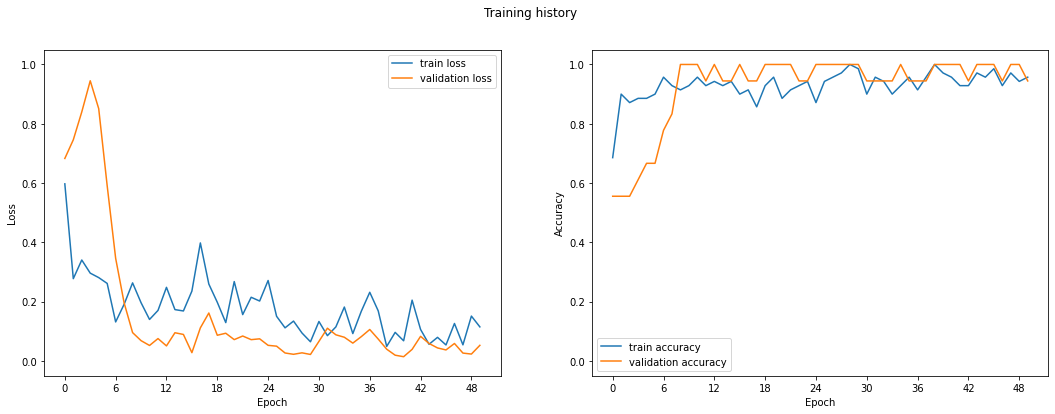

In [39]:
# plot model loss and accuracy
plot_training_history(history, save_path=acc_loss_png)

In [40]:
# Get model prediction
y_pred, y_test = get_predictions(real_model,valid_data_loader, device)
print("The validation set",len(valid_data_loader))
# Get model precision, recall and f1_score
print(classification_report(y_test, y_pred, target_names=class_name))

The validation set 2
              precision    recall  f1-score   support

         neg       1.00      1.00      1.00         5
         pos       1.00      1.00      1.00         3

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



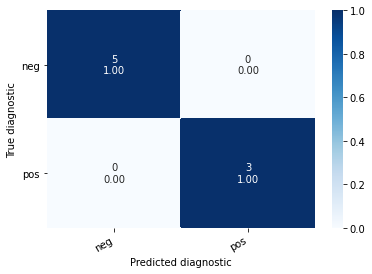

In [41]:
# Get model confusion matrix
cm = confusion_matrix(y_test, y_pred)
confusion_matrix2(cm, class_name,save_path=confusion_png)

In [42]:
prediction = predict_probability(real_model,validation_transforms, image_path, device)

In [43]:
prediction

array([0.8727084 , 0.09273286], dtype=float32)

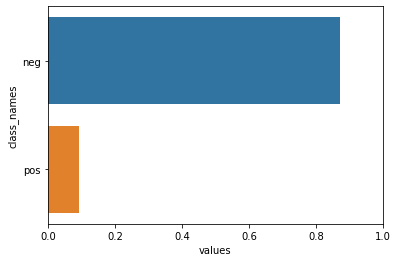

In [44]:
show_prediction_confidence(prediction, class_name)

Model Interpretation

Performing Integrated Gradients Model Interpretation integrated gradients
Predicted: negative ( 0.9853106737136841 )


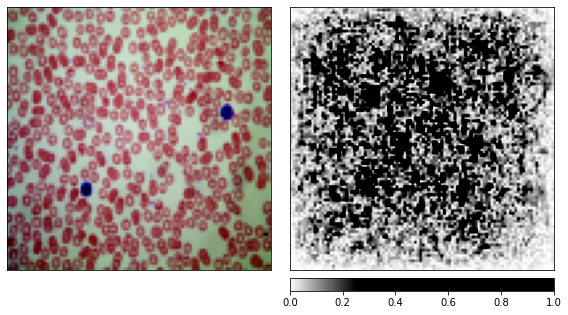

Performing Gradient Shap Model Interpretation gradient shap
Predicted: negative ( 0.9853106737136841 )


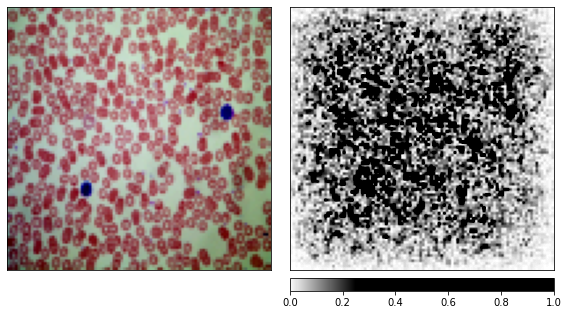

Performing Saliency Model Interpretation saliency
Predicted: negative ( 0.9853106737136841 )


/home/allen/anaconda3/envs/ALL-PyTorch-2020/lib/python3.8/site-packages/captum/_utils/gradient.py:53: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


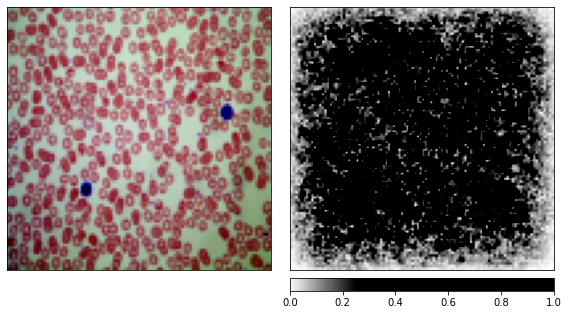

Performing Integrated Gradients Model Interpretation integrated gradients
Predicted: positive ( 0.9999947547912598 )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


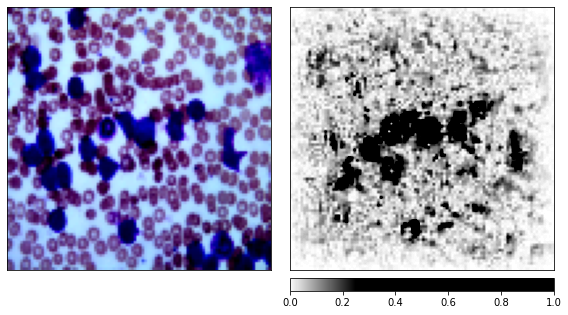

Performing Gradient Shap Model Interpretation gradient shap
Predicted: positive ( 0.9999947547912598 )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


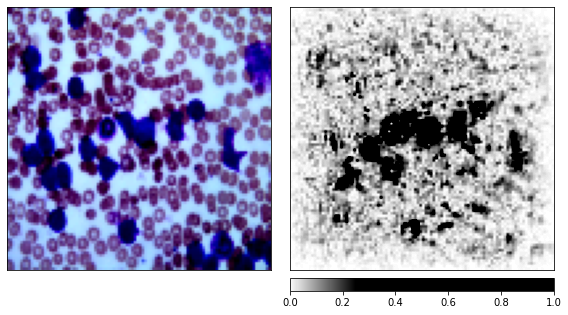

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Performing Saliency Model Interpretation saliency
Predicted: positive ( 0.9999947547912598 )


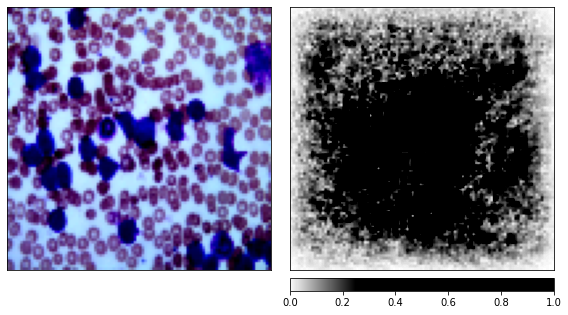

In [45]:
#prediction = predict_probability(real_model, validation_transforms, image_path)
interpret_model(real_model,validation_transforms, image_path, label_idx, use_cpu=True, intrepret_type="integrated gradients")
interpret_model(real_model,validation_transforms, image_path, label_idx, use_cpu=True, intrepret_type="gradient shap")
interpret_model(real_model,validation_transforms, image_path, label_idx, use_cpu=True, intrepret_type="saliency")

interpret_model(real_model,validation_transforms, image_path2, label_idx, use_cpu=True, intrepret_type="integrated gradients")
interpret_model(real_model,validation_transforms, image_path2, label_idx, use_cpu=True, intrepret_type="gradient shap")
interpret_model(real_model,validation_transforms, image_path2, label_idx, use_cpu=True, intrepret_type="saliency")

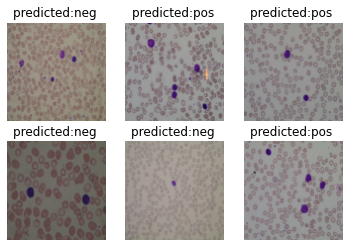

In [46]:
#train data directory
test_dir = '/home/allen/Drive C/Peter Moss AML Leukemia Research/Dataset/all_test/'
test_csv = '/home/allen/Drive C/Peter Moss AML Leukemia Research/Dataset/test.csv'
label_csv = pd.read_csv(test_csv)
testset = LeukemiaDataset(df_data=label_csv, data_dir=test_dir, transform=validation_transforms)
test_data_loader = DataLoader(testset, batch_size=batch_size, shuffle=True)
show_predictions(model=real_model, class_names=class_name,
                 test_data_loader=test_data_loader,
                 device=device, n_images=6)